# Halofit Emulation

In [1]:
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
import keras
import hyperopt
import train_utils as utils
from train_utils import params, lims, ref
# Don't worry about tensorflow warnings

2023-05-18 11:28:00.917799: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-18 11:28:00.944677: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Train redshifts
redshifts = [0, 0.5, 1.0, 2.0, 3.0]

### 1. Data preprocessing
**How to use**: select the desired dataset in `path_to_train` and run all subsequent cells until the [training section](#Training).

**Pipeline description**:
- Load chosen training data
- Smear BAO in linear $P(k)$ (using BACCO's code)
- Calculate $Q(k) = \log(P_\mathrm{NL}/P_\mathrm{lin,\, smear})$
- Normalize cosmological parameters based on EE2 box boundaries
- Normalize $Q$ using min-max
- Save $Q$ normalization parameters (for rescaling $Q$ after emulation)
- PCA
- Normalize PCs using min-max
- Save PC normalization parameters

In [3]:
# Data can be downloaded at https://github.com/SBU-Jonathan/halofit_data
path_to_spectra = "/home/grads/data/jonathan/halofit_data/"
path_to_train400_0percent = path_to_spectra + "lcdm/0_percent/400"
path_to_train400_10percent = path_to_spectra + "lcdm/10_percent/400"
path_to_train400_20percent = path_to_spectra + "lcdm/20_percent/400"
path_to_train800_0percent = path_to_spectra + "lcdm/0_percent/800"
path_to_train800_10percent = path_to_spectra + "lcdm/10_percent/800"
path_to_train800_20percent = path_to_spectra + "lcdm/20_percent/800"

In [4]:
# Select which training dataset to use
path_to_train = path_to_train400_0percent

In [5]:
# Load training LHS
train_samples = np.loadtxt(f"{path_to_train}/lhs.txt")
print(train_samples[0])

[2.69615361e-01 4.03523877e-02 9.45453600e-01 2.24313107e-09
 6.76893375e-01]


In [6]:
# Load ref cosmology from CAMB, all redshifts
pk_lin_ref = np.zeros((len(redshifts), len(utils.ks_400)))
pk_nl_ref = np.zeros((len(redshifts), len(utils.ks_400)))
pk_lin_smear_ref = np.zeros((len(redshifts), len(utils.ks_400)))
for i, redshift in enumerate(redshifts):
    ks, pk_lin_ref[i], pk_nl_ref[i] = np.loadtxt(f"{path_to_train}/pk_ref_z_{redshift:.3f}.txt", unpack=True)
    pk_lin_smear_ref[i] = utils._smeared_bao_pk(k_lin=ks, pk_lin=pk_lin_ref[i], k_emu=ks, pk_lin_emu=pk_lin_ref[i])
ref_boost = pk_nl_ref/pk_lin_ref
ref_expq = pk_nl_ref/pk_lin_smear_ref

In [7]:
# Load training data, 400 spectra
pks_lin_train = np.zeros((len(train_samples), len(redshifts), len(utils.ks_400)))
pks_lin_smear_train = np.zeros((len(train_samples), len(redshifts), len(utils.ks_400)))
pks_nl_train = np.zeros((len(train_samples), len(redshifts), len(utils.ks_400)))

for i in range(len(train_samples)):
    for j, redshift in enumerate(redshifts):
        ks, pks_lin_train[i,j], pks_nl_train[i,j] = np.loadtxt(f"{path_to_train}/pk_{i}_z_{redshift:.3f}.txt", unpack=True)
        pks_lin_smear_train[i,j] = utils._smeared_bao_pk(k_lin=ks, pk_lin=pks_lin_train[i,j], k_emu=ks, pk_lin_emu=pks_lin_train[i,j])

In [8]:
# Defining emulated quantities
train_logboosts = np.zeros((len(train_samples), len(redshifts), len(utils.ks_400)))
train_qs = np.zeros((len(train_samples), len(redshifts), len(utils.ks_400)))
for i in range(len(train_samples)):
    r_nl = pks_nl_train[i]/pk_nl_ref
    r_lin = pks_lin_train[i]/pk_lin_ref
    r_lin_smear = pks_lin_smear_train[i]/pk_lin_smear_ref
    train_logboosts[i] = np.log(ref_boost * r_nl / r_lin)
    train_qs[i] = np.log(ref_expq * r_nl / r_lin_smear)

In [9]:
# Normalized parameters - input for NN
train_sample_norm = np.zeros((len(train_samples),5))
for i, train_point in enumerate(train_samples):
    train_sample_norm[i] = utils.normalize_params(train_point)
print(train_sample_norm[10])

[0.97611409 0.97779688 0.14840044 0.26104241 0.6251285 ]


In [10]:
# Normalized Boosts with Min-Max
train_logboosts_norm = np.zeros((len(train_samples), len(redshifts), len(ks)))
train_qs_norm = np.zeros((len(train_samples), len(redshifts), len(ks)))
for i in range(len(redshifts)):
    train_logboosts_norm[:,i,:] = utils.normalize_array(train_logboosts[:,i,:]) # I normalize within each redshift
    train_qs_norm[:,i,:] = utils.normalize_array(train_qs[:,i,:]) # I normalize within each redshift

In [11]:
# Getting and saving min and max for rescaling
mins_logboosts = np.zeros(len(redshifts))
maxs_logboosts = np.zeros(len(redshifts))
mins_qs = np.zeros(len(redshifts))
maxs_qs = np.zeros(len(redshifts))

for i in range(len(redshifts)):
    mins_logboosts[i] = np.amin(train_logboosts[:,i,:])
    maxs_logboosts[i] = np.amax(train_logboosts[:,i,:])
    mins_qs[i] = np.amin(train_qs[:,i,:])
    maxs_qs[i] = np.amax(train_qs[:,i,:])

In [12]:
# PCA reduction
num_pcs = 6
pcas_logboosts, train_logboosts_pcs = utils.pca_reduction(num_pcs, train_logboosts_norm, redshifts)
pcas_qs, train_qs_pcs = utils.pca_reduction(num_pcs, train_qs_norm, redshifts)

In [13]:
# Normalizing PCs
train_logboosts_pcs_norm = np.zeros((len(train_samples), len(redshifts), num_pcs))
train_qs_pcs_norm = np.zeros((len(train_samples), len(redshifts), num_pcs))
for i in range(len(redshifts)):
    train_logboosts_pcs_norm[:,i] = utils.normalize_array(train_logboosts_pcs[:,i]) # I normalize within each redshift
    train_qs_pcs_norm[:,i] = utils.normalize_array(train_qs_pcs[:,i]) # I normalize within each redshift

# Saving mins and maxs for rescaling
mins_logboosts_pcs = np.zeros((len(redshifts)))
maxs_logboosts_pcs = np.zeros((len(redshifts)))
mins_qs_pcs = np.zeros((len(redshifts)))
maxs_qs_pcs = np.zeros((len(redshifts)))
for i in range(len(redshifts)):
        mins_logboosts_pcs[i] = np.amin(train_logboosts_pcs[:,i])
        maxs_logboosts_pcs[i] = np.amax(train_logboosts_pcs[:,i])
        mins_qs_pcs[i] = np.amin(train_qs_pcs[:,i])
        maxs_qs_pcs[i] = np.amax(train_qs_pcs[:,i])

### Training
**How to use**: 
- Must have run data preprocessing section
- Define your model using the `utils.generate_resnet` or `utils.generate_mlp` functions.
- Train the model using the `utils.nn_model_train` functions, where you can choose to train on `logboosts` or smeared boosts.
- Save your model using `model.save("path")`.

In [14]:
# Generate resnet model
resnet = utils.generate_resnet(
    input_shape=len(train_samples[0]),
    output_shape=num_pcs,
    num_res_blocks=1,
    num_of_neurons=1024,
    alpha=1e-4,
    l1_ratio=0.1,
    dropout=0
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 1024)         6144        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 1024)         1049600     ['dense[0][0]']                  
                                                                                                  
 add (Add)                      (None, 1024)         0           ['dense[0][0]',                  
                                                                  'dense_1[0][0]']            

In [15]:
# Generate MLP model
mlp = utils.generate_mlp(
    input_shape=len(train_samples[0]),
    output_shape=num_pcs,
    num_layers=2,
    num_of_neurons=1024,
    alpha=1e-4,
    l1_ratio=0.1,
    dropout=0
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hid_layer_1 (Dense)         (None, 1024)              6144      
                                                                 
 hid_layer_2 (Dense)         (None, 1024)              1049600   
                                                                 
 out_layer (Dense)           (None, 6)                 6150      
                                                                 
Total params: 1,061,894
Trainable params: 1,061,894
Non-trainable params: 0
_________________________________________________________________


In [68]:
# Training for 2.6k epochs. Starting from epoch 1500, the learning rate halves every 200 epochs
start = perf_counter()
last_loss = utils.nn_model_train(mlp, 1600, train_sample_norm, train_qs_pcs_norm[:,0], decayevery=1500, decayrate=2)
last_loss = utils.nn_model_train(mlp, 1000, train_sample_norm, train_qs_pcs_norm[:,0], decayevery=200, decayrate=2)
print(f"Training took {perf_counter() - start} seconds")

Epoch 1/1600
14/14 [==============================] - 1s 5ms/step - loss: 0.5593 - lr: 0.0010
Epoch 2/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.3953 - lr: 0.0010
Epoch 3/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.3133 - lr: 0.0010
Epoch 4/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.2587 - lr: 0.0010
Epoch 5/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.2210 - lr: 0.0010
Epoch 6/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.2007 - lr: 0.0010
Epoch 7/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.1806 - lr: 0.0010
Epoch 8/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.1679 - lr: 0.0010
Epoch 9/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.1637 - lr: 0.0010
Epoch 10/1600
14/14 [==============================] - 0s 3ms/step - loss: 0.1573 - lr: 0.0010
Epoch 11/1600
14/14 [==============================] - 0s 4

14/14 [==============================] - 0s 4ms/step - loss: 0.0111 - lr: 0.0010
Epoch 88/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0117 - lr: 0.0010
Epoch 89/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0110 - lr: 0.0010
Epoch 90/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0109 - lr: 0.0010
Epoch 91/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0112 - lr: 0.0010
Epoch 92/1600
14/14 [==============================] - 0s 3ms/step - loss: 0.0110 - lr: 0.0010
Epoch 93/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0111 - lr: 0.0010
Epoch 94/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0104 - lr: 0.0010
Epoch 95/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0112 - lr: 0.0010
Epoch 96/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0112 - lr: 0.0010
Epoch 97/1600
14/14 [==============================] - 0s 4ms/st

14/14 [==============================] - 0s 4ms/step - loss: 0.0080 - lr: 0.0010
Epoch 173/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0075 - lr: 0.0010
Epoch 174/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0074 - lr: 0.0010
Epoch 175/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0071 - lr: 0.0010
Epoch 176/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0074 - lr: 0.0010
Epoch 177/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0074 - lr: 0.0010
Epoch 178/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0072 - lr: 0.0010
Epoch 179/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0080 - lr: 0.0010
Epoch 180/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0079 - lr: 0.0010
Epoch 181/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0094 - lr: 0.0010
Epoch 182/1600
14/14 [==============================] -

14/14 [==============================] - 0s 4ms/step - loss: 0.0062 - lr: 0.0010
Epoch 258/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0059 - lr: 0.0010
Epoch 259/1600
14/14 [==============================] - 0s 3ms/step - loss: 0.0062 - lr: 0.0010
Epoch 260/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0067 - lr: 0.0010
Epoch 261/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0064 - lr: 0.0010
Epoch 262/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0070 - lr: 0.0010
Epoch 263/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0064 - lr: 0.0010
Epoch 264/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0068 - lr: 0.0010
Epoch 265/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0062 - lr: 0.0010
Epoch 266/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0057 - lr: 0.0010
Epoch 267/1600
14/14 [==============================] -

14/14 [==============================] - 0s 3ms/step - loss: 0.0060 - lr: 0.0010
Epoch 343/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0055 - lr: 0.0010
Epoch 344/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0056 - lr: 0.0010
Epoch 345/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0050 - lr: 0.0010
Epoch 346/1600
14/14 [==============================] - 0s 3ms/step - loss: 0.0054 - lr: 0.0010
Epoch 347/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0056 - lr: 0.0010
Epoch 348/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0054 - lr: 0.0010
Epoch 349/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0049 - lr: 0.0010
Epoch 350/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0063 - lr: 0.0010
Epoch 351/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0076 - lr: 0.0010
Epoch 352/1600
14/14 [==============================] -

14/14 [==============================] - 0s 3ms/step - loss: 0.0050 - lr: 0.0010
Epoch 428/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0059 - lr: 0.0010
Epoch 429/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0059 - lr: 0.0010
Epoch 430/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0056 - lr: 0.0010
Epoch 431/1600
14/14 [==============================] - 0s 3ms/step - loss: 0.0057 - lr: 0.0010
Epoch 432/1600
14/14 [==============================] - 0s 3ms/step - loss: 0.0058 - lr: 0.0010
Epoch 433/1600
14/14 [==============================] - 0s 3ms/step - loss: 0.0055 - lr: 0.0010
Epoch 434/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0049 - lr: 0.0010
Epoch 435/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0052 - lr: 0.0010
Epoch 436/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0049 - lr: 0.0010
Epoch 437/1600
14/14 [==============================] -

14/14 [==============================] - 0s 3ms/step - loss: 0.0049 - lr: 0.0010
Epoch 513/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0046 - lr: 0.0010
Epoch 514/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0042 - lr: 0.0010
Epoch 515/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0047 - lr: 0.0010
Epoch 516/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0045 - lr: 0.0010
Epoch 517/1600
14/14 [==============================] - 0s 3ms/step - loss: 0.0048 - lr: 0.0010
Epoch 518/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0047 - lr: 0.0010
Epoch 519/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0050 - lr: 0.0010
Epoch 520/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0048 - lr: 0.0010
Epoch 521/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0052 - lr: 0.0010
Epoch 522/1600
14/14 [==============================] -

14/14 [==============================] - 0s 4ms/step - loss: 0.0043 - lr: 0.0010
Epoch 598/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0042 - lr: 0.0010
Epoch 599/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0050 - lr: 0.0010
Epoch 600/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0047 - lr: 0.0010
Epoch 601/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0044 - lr: 0.0010
Epoch 602/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0040 - lr: 0.0010
Epoch 603/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0043 - lr: 0.0010
Epoch 604/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0046 - lr: 0.0010
Epoch 605/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0049 - lr: 0.0010
Epoch 606/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0047 - lr: 0.0010
Epoch 607/1600
14/14 [==============================] -

14/14 [==============================] - 0s 4ms/step - loss: 0.0045 - lr: 0.0010
Epoch 683/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0050 - lr: 0.0010
Epoch 684/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0047 - lr: 0.0010
Epoch 685/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0044 - lr: 0.0010
Epoch 686/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0041 - lr: 0.0010
Epoch 687/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0044 - lr: 0.0010
Epoch 688/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0050 - lr: 0.0010
Epoch 689/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0044 - lr: 0.0010
Epoch 690/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0052 - lr: 0.0010
Epoch 691/1600
14/14 [==============================] - 0s 3ms/step - loss: 0.0050 - lr: 0.0010
Epoch 692/1600
14/14 [==============================] -

14/14 [==============================] - 0s 4ms/step - loss: 0.0043 - lr: 0.0010
Epoch 768/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0041 - lr: 0.0010
Epoch 769/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0042 - lr: 0.0010
Epoch 770/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0042 - lr: 0.0010
Epoch 771/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0052 - lr: 0.0010
Epoch 772/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0049 - lr: 0.0010
Epoch 773/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0046 - lr: 0.0010
Epoch 774/1600
14/14 [==============================] - 0s 3ms/step - loss: 0.0050 - lr: 0.0010
Epoch 775/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0054 - lr: 0.0010
Epoch 776/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0053 - lr: 0.0010
Epoch 777/1600
14/14 [==============================] -

14/14 [==============================] - 0s 4ms/step - loss: 0.0041 - lr: 0.0010
Epoch 853/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0038 - lr: 0.0010
Epoch 854/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0039 - lr: 0.0010
Epoch 855/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0043 - lr: 0.0010
Epoch 856/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0044 - lr: 0.0010
Epoch 857/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0045 - lr: 0.0010
Epoch 858/1600
14/14 [==============================] - 0s 3ms/step - loss: 0.0044 - lr: 0.0010
Epoch 859/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0045 - lr: 0.0010
Epoch 860/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0043 - lr: 0.0010
Epoch 861/1600
14/14 [==============================] - 0s 3ms/step - loss: 0.0040 - lr: 0.0010
Epoch 862/1600
14/14 [==============================] -

14/14 [==============================] - 0s 4ms/step - loss: 0.0040 - lr: 0.0010
Epoch 938/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0039 - lr: 0.0010
Epoch 939/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0041 - lr: 0.0010
Epoch 940/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0040 - lr: 0.0010
Epoch 941/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0041 - lr: 0.0010
Epoch 942/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0039 - lr: 0.0010
Epoch 943/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0044 - lr: 0.0010
Epoch 944/1600
14/14 [==============================] - 0s 3ms/step - loss: 0.0040 - lr: 0.0010
Epoch 945/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0036 - lr: 0.0010
Epoch 946/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0044 - lr: 0.0010
Epoch 947/1600
14/14 [==============================] -

14/14 [==============================] - 0s 4ms/step - loss: 0.0055 - lr: 0.0010
Epoch 1023/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0047 - lr: 0.0010
Epoch 1024/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0043 - lr: 0.0010
Epoch 1025/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0046 - lr: 0.0010
Epoch 1026/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0042 - lr: 0.0010
Epoch 1027/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0045 - lr: 0.0010
Epoch 1028/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0043 - lr: 0.0010
Epoch 1029/1600
14/14 [==============================] - 0s 3ms/step - loss: 0.0040 - lr: 0.0010
Epoch 1030/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0037 - lr: 0.0010
Epoch 1031/1600
14/14 [==============================] - 0s 3ms/step - loss: 0.0040 - lr: 0.0010
Epoch 1032/1600
14/14 [=======================

14/14 [==============================] - 0s 4ms/step - loss: 0.0045 - lr: 0.0010
Epoch 1107/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0038 - lr: 0.0010
Epoch 1108/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0039 - lr: 0.0010
Epoch 1109/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0041 - lr: 0.0010
Epoch 1110/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0040 - lr: 0.0010
Epoch 1111/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0039 - lr: 0.0010
Epoch 1112/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0042 - lr: 0.0010
Epoch 1113/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0043 - lr: 0.0010
Epoch 1114/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0039 - lr: 0.0010
Epoch 1115/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0037 - lr: 0.0010
Epoch 1116/1600
14/14 [=======================

14/14 [==============================] - 0s 4ms/step - loss: 0.0040 - lr: 0.0010
Epoch 1191/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0045 - lr: 0.0010
Epoch 1192/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0038 - lr: 0.0010
Epoch 1193/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0041 - lr: 0.0010
Epoch 1194/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 0.0010
Epoch 1195/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0050 - lr: 0.0010
Epoch 1196/1600
14/14 [==============================] - 0s 3ms/step - loss: 0.0045 - lr: 0.0010
Epoch 1197/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0043 - lr: 0.0010
Epoch 1198/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0040 - lr: 0.0010
Epoch 1199/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0039 - lr: 0.0010
Epoch 1200/1600
14/14 [=======================

14/14 [==============================] - 0s 4ms/step - loss: 0.0045 - lr: 0.0010
Epoch 1275/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0052 - lr: 0.0010
Epoch 1276/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0050 - lr: 0.0010
Epoch 1277/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0043 - lr: 0.0010
Epoch 1278/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0039 - lr: 0.0010
Epoch 1279/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0044 - lr: 0.0010
Epoch 1280/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0042 - lr: 0.0010
Epoch 1281/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0038 - lr: 0.0010
Epoch 1282/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0037 - lr: 0.0010
Epoch 1283/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0035 - lr: 0.0010
Epoch 1284/1600
14/14 [=======================

14/14 [==============================] - 0s 4ms/step - loss: 0.0038 - lr: 0.0010
Epoch 1359/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0038 - lr: 0.0010
Epoch 1360/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0040 - lr: 0.0010
Epoch 1361/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0036 - lr: 0.0010
Epoch 1362/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0038 - lr: 0.0010
Epoch 1363/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0045 - lr: 0.0010
Epoch 1364/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0039 - lr: 0.0010
Epoch 1365/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0040 - lr: 0.0010
Epoch 1366/1600
14/14 [==============================] - 0s 3ms/step - loss: 0.0042 - lr: 0.0010
Epoch 1367/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0044 - lr: 0.0010
Epoch 1368/1600
14/14 [=======================

14/14 [==============================] - 0s 4ms/step - loss: 0.0036 - lr: 0.0010
Epoch 1443/1600
14/14 [==============================] - 0s 3ms/step - loss: 0.0038 - lr: 0.0010
Epoch 1444/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0047 - lr: 0.0010
Epoch 1445/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0047 - lr: 0.0010
Epoch 1446/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0042 - lr: 0.0010
Epoch 1447/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0043 - lr: 0.0010
Epoch 1448/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0043 - lr: 0.0010
Epoch 1449/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0036 - lr: 0.0010
Epoch 1450/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0039 - lr: 0.0010
Epoch 1451/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0036 - lr: 0.0010
Epoch 1452/1600
14/14 [=======================

14/14 [==============================] - 0s 4ms/step - loss: 0.0022 - lr: 5.0000e-04
Epoch 1526/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0023 - lr: 5.0000e-04
Epoch 1527/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0022 - lr: 5.0000e-04
Epoch 1528/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0022 - lr: 5.0000e-04
Epoch 1529/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0027 - lr: 5.0000e-04
Epoch 1530/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0025 - lr: 5.0000e-04
Epoch 1531/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0022 - lr: 5.0000e-04
Epoch 1532/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0022 - lr: 5.0000e-04
Epoch 1533/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0022 - lr: 5.0000e-04
Epoch 1534/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0022 - lr: 5.0000e-04
Epoch 

14/14 [==============================] - 0s 4ms/step - loss: 0.0022 - lr: 5.0000e-04
Epoch 7/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0021 - lr: 5.0000e-04
Epoch 8/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0022 - lr: 5.0000e-04
Epoch 9/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0022 - lr: 5.0000e-04
Epoch 10/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0023 - lr: 5.0000e-04
Epoch 11/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0023 - lr: 5.0000e-04
Epoch 12/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0026 - lr: 5.0000e-04
Epoch 13/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0025 - lr: 5.0000e-04
Epoch 14/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0023 - lr: 5.0000e-04
Epoch 15/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0022 - lr: 5.0000e-04
Epoch 16/1000
14/14 [======

Epoch 89/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0023 - lr: 5.0000e-04
Epoch 90/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0024 - lr: 5.0000e-04
Epoch 91/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0024 - lr: 5.0000e-04
Epoch 92/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0027 - lr: 5.0000e-04
Epoch 93/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0025 - lr: 5.0000e-04
Epoch 94/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0025 - lr: 5.0000e-04
Epoch 95/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0026 - lr: 5.0000e-04
Epoch 96/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0022 - lr: 5.0000e-04
Epoch 97/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0024 - lr: 5.0000e-04
Epoch 98/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0024 - lr: 5.0000e-04
Epoch 99/1

14/14 [==============================] - 0s 4ms/step - loss: 0.0026 - lr: 5.0000e-04
Epoch 172/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0024 - lr: 5.0000e-04
Epoch 173/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0023 - lr: 5.0000e-04
Epoch 174/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0023 - lr: 5.0000e-04
Epoch 175/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0023 - lr: 5.0000e-04
Epoch 176/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0024 - lr: 5.0000e-04
Epoch 177/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0025 - lr: 5.0000e-04
Epoch 178/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0025 - lr: 5.0000e-04
Epoch 179/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0024 - lr: 5.0000e-04
Epoch 180/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0023 - lr: 5.0000e-04
Epoch 181/1000


14/14 [==============================] - 0s 4ms/step - loss: 0.0017 - lr: 2.5000e-04
Epoch 254/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 2.5000e-04
Epoch 255/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 2.5000e-04
Epoch 256/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 2.5000e-04
Epoch 257/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 2.5000e-04
Epoch 258/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 2.5000e-04
Epoch 259/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 2.5000e-04
Epoch 260/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0018 - lr: 2.5000e-04
Epoch 261/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0018 - lr: 2.5000e-04
Epoch 262/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 2.5000e-04
Epoch 263/1000


14/14 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 2.5000e-04
Epoch 336/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0017 - lr: 2.5000e-04
Epoch 337/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0017 - lr: 2.5000e-04
Epoch 338/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 2.5000e-04
Epoch 339/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0017 - lr: 2.5000e-04
Epoch 340/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 2.5000e-04
Epoch 341/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 2.5000e-04
Epoch 342/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 2.5000e-04
Epoch 343/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 2.5000e-04
Epoch 344/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 2.5000e-04
Epoch 345/1000


14/14 [==============================] - 0s 5ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 418/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 419/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 420/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 421/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 422/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 423/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 424/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 425/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 426/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 427/1000


14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 500/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015 - lr: 1.2500e-04
Epoch 501/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 502/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 503/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 504/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 505/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 506/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 507/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 508/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 509/1000


14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 582/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 583/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 584/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 585/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 586/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 587/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 588/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 589/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 590/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 1.2500e-04
Epoch 591/1000


14/14 [==============================] - 0s 4ms/step - loss: 0.0013 - lr: 6.2500e-05
Epoch 664/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013 - lr: 6.2500e-05
Epoch 665/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013 - lr: 6.2500e-05
Epoch 666/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013 - lr: 6.2500e-05
Epoch 667/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013 - lr: 6.2500e-05
Epoch 668/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013 - lr: 6.2500e-05
Epoch 669/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013 - lr: 6.2500e-05
Epoch 670/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013 - lr: 6.2500e-05
Epoch 671/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013 - lr: 6.2500e-05
Epoch 672/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013 - lr: 6.2500e-05
Epoch 673/1000


14/14 [==============================] - 0s 4ms/step - loss: 0.0013 - lr: 6.2500e-05
Epoch 746/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013 - lr: 6.2500e-05
Epoch 747/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013 - lr: 6.2500e-05
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013 - lr: 6.2500e-05
Epoch 749/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013 - lr: 6.2500e-05
Epoch 750/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013 - lr: 6.2500e-05
Epoch 751/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 6.2500e-05
Epoch 752/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013 - lr: 6.2500e-05
Epoch 753/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013 - lr: 6.2500e-05
Epoch 754/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 6.2500e-05
Epoch 755/1000


14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 828/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 829/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 830/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 831/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 832/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 833/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 834/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 835/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 836/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 837/1000


14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 910/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 911/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 912/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 913/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 914/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 915/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 916/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 917/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 918/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 919/1000


14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 992/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 993/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 994/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 995/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 996/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 997/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 998/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 999/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 3.1250e-05
Epoch 1000/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.1250e-05
Training took 

In [69]:
mlp.save("models/mlp_smear")

INFO:tensorflow:Assets written to: models/mlp_smear/assets


INFO:tensorflow:Assets written to: models/mlp_smear/assets


### Load test data
**How to use**: run the following cells until [Evaluation Results](#Evaluation-Results) section

**Description**: Loads the test data to evaluate the models.

In [23]:
path_to_spectra = "/home/grads/data/jonathan/halofit_data/lcdm"
path_to_test_spectra = f"{path_to_spectra}/0_percent/300"
test_samples = np.loadtxt(f"{path_to_test_spectra}/lhs.txt")
print(test_samples[0])
ks = np.loadtxt(f"{path_to_test_spectra}/pk_ref_z_0.000.txt", unpack=True, usecols=(0))

[3.96686122e-01 4.49730022e-02 9.87595752e-01 1.90699488e-09
 6.18228503e-01]


In [24]:
pks_lin_test = np.zeros((len(test_samples), len(redshifts), len(ks)))
pks_lin_smear_test = np.zeros((len(test_samples), len(redshifts), len(ks)))
pks_nl_test = np.zeros((len(test_samples), len(redshifts), len(ks)))

for i in range(len(test_samples)):
    for j, redshift in enumerate(redshifts):
        ks, pks_lin_test[i,j], pks_nl_test[i,j] = np.loadtxt(f"{path_to_test_spectra}/pk_{i}_z_{redshift:.3f}.txt", unpack=True)
        pks_lin_smear_test[i,j] = utils._smeared_bao_pk(k_lin=ks, pk_lin=pks_lin_test[i,j], k_emu=ks, pk_lin_emu=pks_lin_test[i,j])

In [25]:
test_boosts = pks_nl_test/pks_lin_test
test_expqs = pks_nl_test/pks_lin_smear_test

In [51]:
def evaluate_model(model, test_lhs, test_data, z_index, smear):
    """
    Generates a plot of relative errors
    """
    bad_cosmologies = 0
    fig = plt.figure()
    for i, (test_sample, test_boost) in enumerate(zip(test_lhs, test_data)):
        test_params_norm = utils.normalize_params(test_sample)
        model_output = model(np.array([test_params_norm])) # Normalized PCs
        if not smear:
            output_pcs = model_output * (maxs_logboosts_pcs[z_index] - mins_logboosts_pcs[z_index]) + mins_logboosts_pcs[z_index] # PCs
            output_norm_logboost = pcas_logboosts[z_index].inverse_transform(output_pcs) # Norm logboost
            output_logboost = output_norm_logboost * (maxs_logboosts[z_index] - mins_logboosts[z_index]) + mins_logboosts[z_index] # Logboost
        else:
            output_pcs = model_output * (maxs_qs_pcs[z_index] - mins_qs_pcs[z_index]) + mins_qs_pcs[z_index] # PCs
            output_norm_q = pcas_qs[z_index].inverse_transform(output_pcs) # Norm logboost
            output_logboost = output_norm_q * (maxs_qs[z_index] - mins_qs[z_index]) + mins_qs[z_index] # Logboost
        output_boost = np.exp(output_logboost)[0] # Boost
        errors = output_boost/test_boost[z_index] - 1
        plt.semilogx(ks, errors)
        if np.any(np.abs(errors) > 0.005):
            bad_cosmologies += 1
    plt.xlabel('$k \;\; (h/\mathrm{Mpc})$')
    plt.ylabel('$B_{emu} / B_{Halofit} - 1$')
    plt.ylim([-0.02, 0.02])
    plt.xlim([0.01, 3])
    print(f"Number of cosmologies with error > 0.005: {bad_cosmologies} out of {len(test_lhs)}")
    plt.grid()
    return fig # in case you want to save, just use fig.savefig("name.pdf"); add title with figure.suptitle("Title")

In [35]:
# Experimenting ensemble models: taking the average of multiple NN models
def evaluate_ensemble(model1, model2, test_lhs, test_data, z_index, smear):
    """
    Generates a plot of relative errors
    """
    bad_cosmologies = 0
    fig = plt.figure()
    for i, (test_sample, test_boost) in enumerate(zip(test_lhs, test_data)):
        test_params_norm = utils.normalize_params(test_sample)
        model1_output = model1(np.array([test_params_norm]))
        model2_output = model2(np.array([test_params_norm]))
        ensemble_output = (model1_output + model2_output)/2
        if not smear:
            output_pcs = ensemble_output * (maxs_logboosts_pcs[z_index] - mins_logboosts_pcs[z_index]) + mins_logboosts_pcs[z_index] # PCs
            output_norm_logboost = pcas_logboosts[z_index].inverse_transform(output_pcs) # Norm logboost
            output_logboost = output_norm_logboost * (maxs_logboosts[z_index] - mins_logboosts[z_index]) + mins_logboosts[z_index] # Logboost
        else:
            output_pcs = ensemble_output * (maxs_qs_pcs[z_index] - mins_qs_pcs[z_index]) + mins_qs_pcs[z_index] # PCs
            output_norm_q = pcas_qs[z_index].inverse_transform(output_pcs) # Norm logboost
            output_logboost = output_norm_q * (maxs_qs[z_index] - mins_qs[z_index]) + mins_qs[z_index] # Logboost
        output_boost = np.exp(output_logboost)[0] # Boost
        errors = output_boost/test_boost[z_index] - 1
        plt.semilogx(ks, errors)
        if np.any(np.abs(errors) > 0.005):
            bad_cosmologies += 1
    plt.xlabel('$k \;\; (h/\mathrm{Mpc})$')
    plt.ylabel('$B_{emu} / B_{Halofit} - 1$')
    plt.ylim([-0.02, 0.02])
    plt.xlim([0.01, 3])
    print(f"Number of cosmologies with error > 0.005: {bad_cosmologies} out of {len(test_lhs)}")
    plt.grid()
    return fig # in case you want to save, just use fig.savefig("name.pdf"); add title with figure.suptitle("Title")

### Evaluation Results
**How to use**: load the model or have an instance of the model in memory. Call the `evaluate_model` function on the test data. Be careful to pass the correct data and `smear` flag. The `evaluate_model` function returns a `matplotlib figure` object to which you can add a title and save.

Number of cosmologies with error > 0.005: 8 out of 300


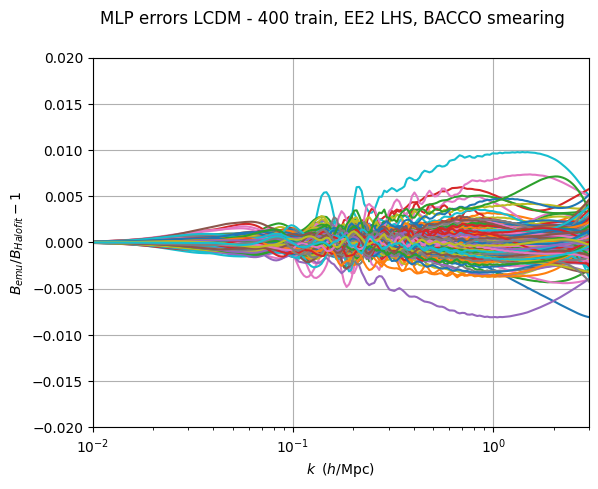

In [70]:
mlp_smeared = keras.models.load_model("models/mlp_smear")
figure = evaluate_model(mlp_smeared, test_samples, test_expqs, 0, smear=True)
figure.suptitle("MLP errors LCDM - 400 train, EE2 LHS, BACCO smearing")
figure.savefig("plots/mlp_smeared_errors.pdf", bbox_inches="tight")

Cosmology 9 in test sample is weird
Number of cosmologies with error > 0.005: 4 out of 300


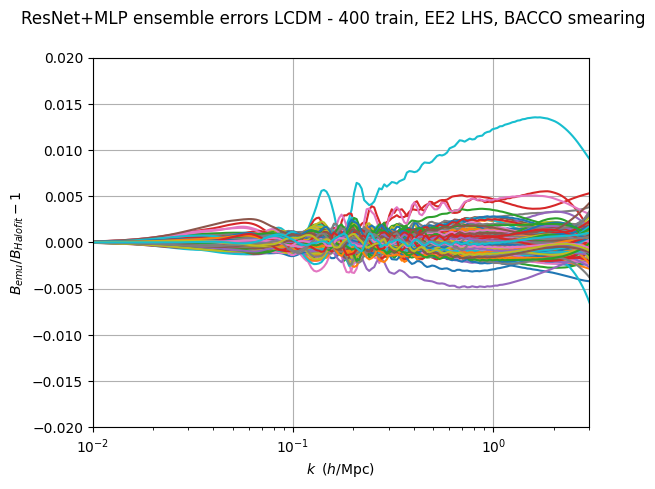

In [71]:
resnet_smeared = keras.models.load_model("models/resnet_smear")
figure = evaluate_ensemble(mlp_smeared, resnet_smeared, test_samples, test_expqs, 0, smear=True)
figure.suptitle("ResNet+MLP ensemble errors LCDM - 400 train, EE2 LHS, BACCO smearing")
figure.savefig("plots/ensemble_errors.pdf", bbox_inches="tight")

Cosmology 252 in test sample is weird
Number of cosmologies with error > 0.005: 1 out of 300


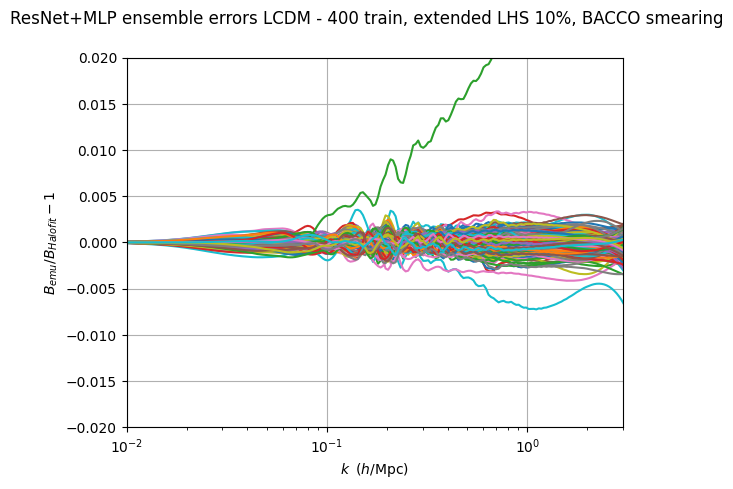

In [36]:
figure = evaluate_ensemble(mlp_smeared_stretch10, resnet_smeared_stretch10, test_samples, test_expqs, 0, smear=True)
figure.suptitle("ResNet+MLP ensemble errors LCDM - 400 train, extended LHS 10%, BACCO smearing")
figure.savefig("plots/ensemble.pdf", bbox_inches="tight")

Cosmology 252 in test sample is weird
Number of cosmologies with error > 0.005: 3 out of 300


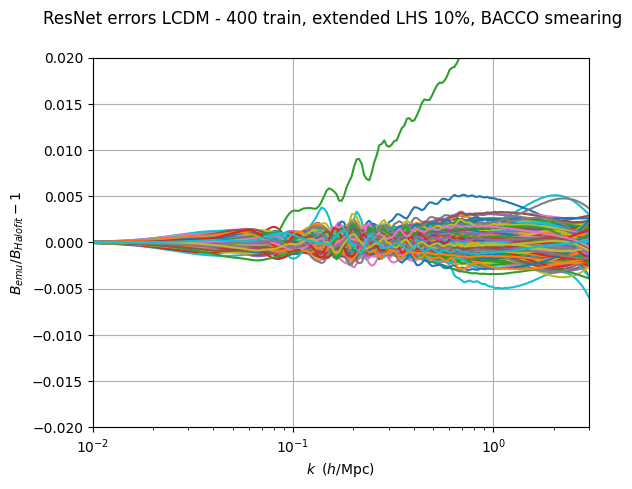

In [32]:
resnet_smeared_stretch10 = keras.models.load_model("models/resnet_smear_stretch10")
figure = evaluate_model(resnet_smeared_stretch10, test_samples, test_expqs, 0, smear=True)
figure.suptitle("ResNet errors LCDM - 400 train, extended LHS 10%, BACCO smearing")
figure.savefig("plots/resnet_smeared_errors_stretchLHS10.pdf", bbox_inches="tight")

Number of cosmologies with error > 0.005: 0 out of 300


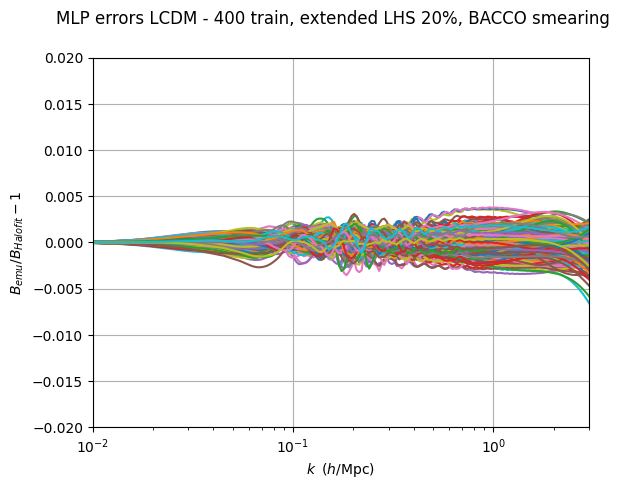

In [52]:
mlp_smeared_stretch20 = keras.models.load_model("models/mlp_smear_stretch20")
figure = evaluate_model(mlp_smeared_stretch20, test_samples, test_expqs, 0, smear=True)
figure.suptitle("MLP errors LCDM - 400 train, extended LHS 20%, BACCO smearing")
figure.savefig("plots/mlp_smeared_errors_stretchLHS20.pdf", bbox_inches="tight")

Number of cosmologies with error > 0.005: 1 out of 300


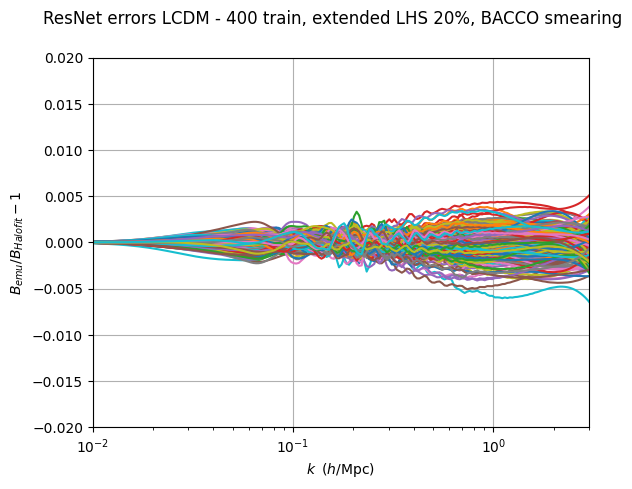

In [53]:
resnet_smeared_stretch20 = keras.models.load_model("models/resnet_smear_stretch20")
figure = evaluate_model(resnet_smeared_stretch20, test_samples, test_expqs, 0, smear=True)
figure.suptitle("ResNet errors LCDM - 400 train, extended LHS 20%, BACCO smearing")
figure.savefig("resnet_smeared_errors_stretchLHS20.pdf", bbox_inches="tight")

Number of cosmologies with error > 0.005: 0 out of 300


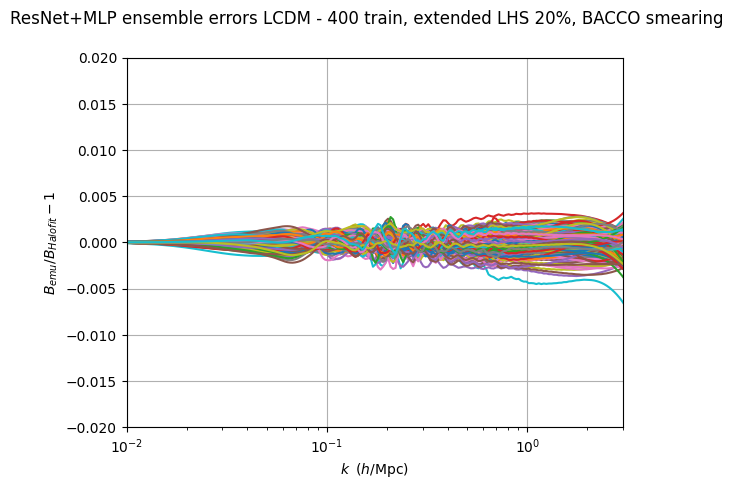

In [54]:
figure = evaluate_ensemble(resnet_smeared_stretch20, mlp_smeared_stretch20, test_samples, test_expqs, 0, smear=True)
figure.suptitle("ResNet+MLP ensemble errors LCDM - 400 train, extended LHS 20%, BACCO smearing")
figure.savefig("ensemble_stretchLHS20.pdf", bbox_inches="tight")

Number of cosmologies with error > 0.005: 4 out of 300


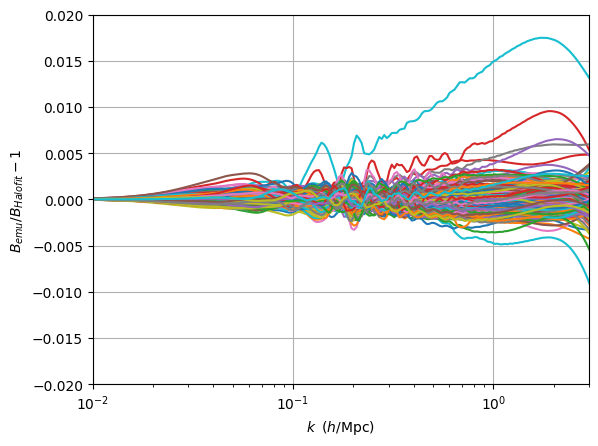

In [65]:
resnet_smeared = keras.models.load_model("models/resnet_smear")
figure = evaluate_model(resnet_smeared, test_samples, test_expqs, 0, smear=True)
figure.suptitle("ResNet errors - 400 train, BACCO smearing")
figure.savefig("resnet_smeared_errors.pdf", bbox_inches="tight")

Number of cosmologies with error > 0.005: 23 out of 300


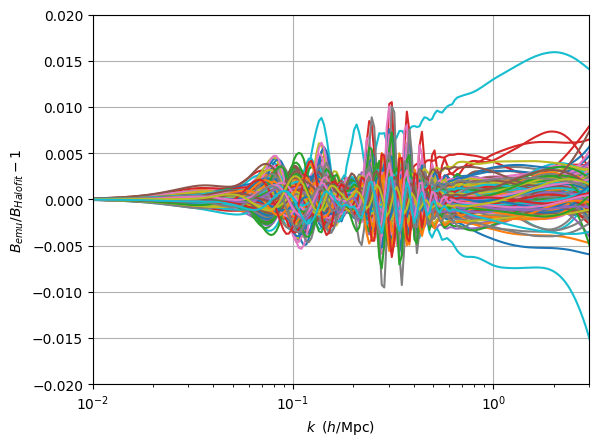

In [74]:
resnet_no_smear = keras.models.load_model("models/resnet_nosmear")
figure = evaluate_model(resnet_no_smear, test_samples, test_boosts, 0, smear=False)
figure.suptitle("ResNet errors - 400 train, no smearing")
figure.savefig("resnet_nosmear_errors.pdf", bbox_inches="tight")